Importing Data

In [8]:
!pip install prophet
!pip install neuralprophet==<compatible version with PyTorch 1.13.1>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `pip install neuralprophet==<compatible version with PyTorch 1.13.1>'


In [10]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import PowerTransformer
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
# from neuralprophet import NeuralProphet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

msft = yf.Ticker("TSLA")

In [11]:
df = msft.history("2y","1d")

In [12]:
df.reset_index(level = 0, inplace = True)

In [13]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')

In [14]:
df = df[['Date', 'Close']]
df['Date'] = df['Date'].apply(lambda x: x.date())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    504 non-null    object 
 1   Close   504 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.0+ KB


In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Close
0,2021-04-29,225.666672
1,2021-04-30,236.479996
2,2021-05-03,228.300003
3,2021-05-04,224.533340
4,2021-05-05,223.646667


Handling Missing Values

In [16]:
date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max())

In [17]:
df1 = df.set_index('Date').reindex(date_range).fillna({'Price': None}).reset_index()
df1 = df1.rename(columns={'index': 'Date'})


In [18]:
df1.tail()

,Date,Close
725,2023-04-24,162.550003
726,2023-04-25,160.669998
727,2023-04-26,153.750000
728,2023-04-27,160.190002
729,2023-04-28,164.309998


In [19]:
df1.isnull().sum()

Date       0
Close    226
dtype: int64

In [20]:
#Imputing missing values with exponential moving average
ema = df1['Close'].ewm(span= 2, min_periods=2).mean()
df1['Close'].fillna(ema, inplace = True)
df1.isnull().sum()

Date     0
Close    0
dtype: int64

Exploratory Data Analysis

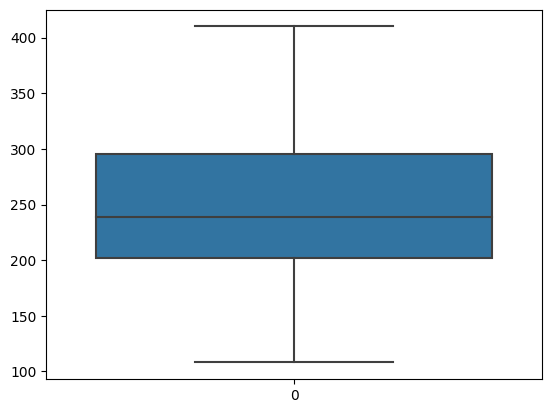

In [21]:
sns.boxplot(df1['Close'])
plt.show()

No Outliers in the data

In [22]:
df1.describe()

,Close
count,730.000000
mean,249.427505
std,64.353160
min,108.099998
25%,202.089172
50%,239.131895
75%,295.258068
max,409.970001


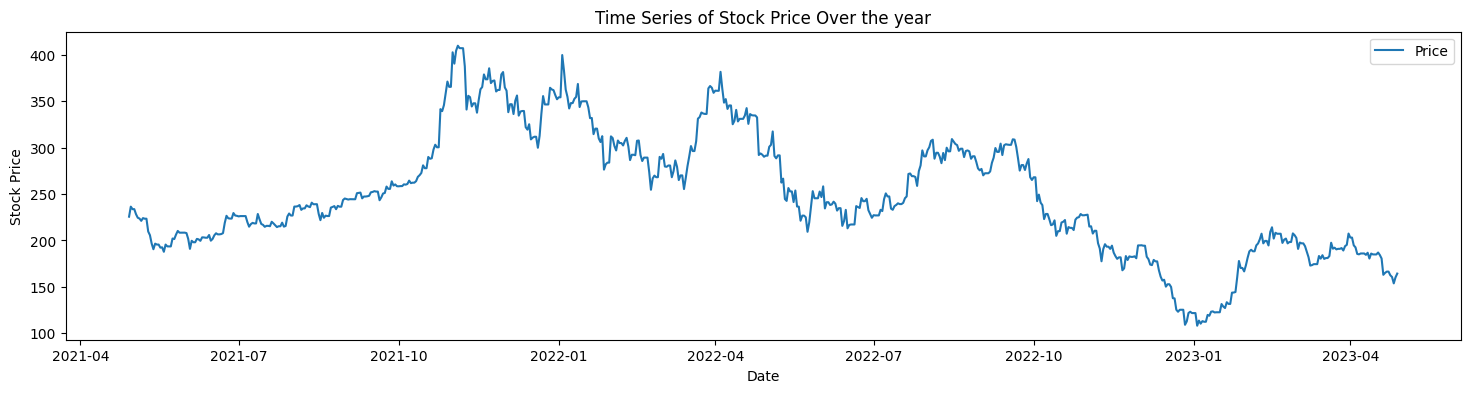

In [23]:
#Visualizing the time series
plt.figure(figsize=(18,4))
plt.plot(df1['Date'],df1['Close'], label = 'Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Time Series of Stock Price Over the year')
plt.legend()

Additive seasonal decomposition is a time series analysis technique that decomposes a time series into four components: trend, seasonality, cyclical, and residual.

In additive seasonal decomposition, the time series is modeled as the sum of the four components:

y(t) = Trend(t) + Seasonality(t) + Cyclical(t) + Residual(t)


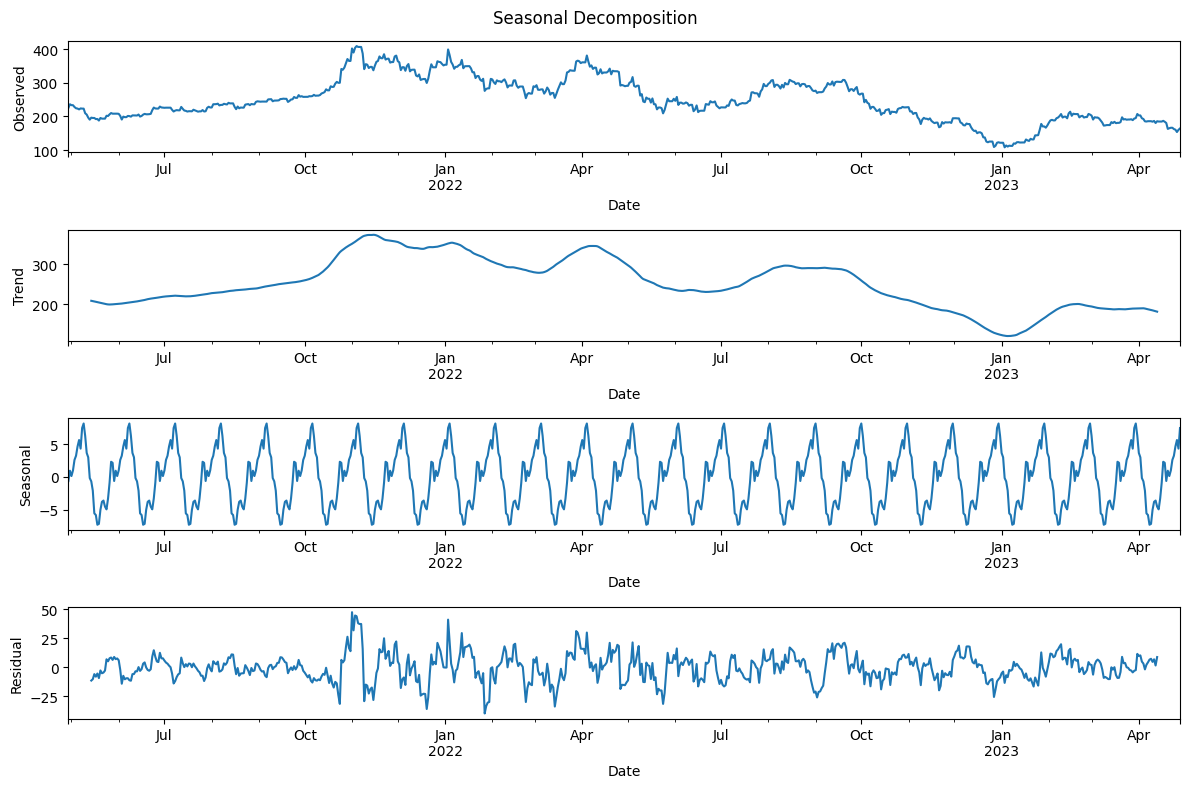

In [24]:
df1.index = df1.Date
decomposition = sm.tsa.seasonal_decompose(df1.Close, model='additive',period = 30)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12,8))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
fig.suptitle('Seasonal Decomposition')
plt.tight_layout()
plt.show()

Multiplicative seasonal decomposition is a time series analysis technique that decomposes a time series into three components: trend, seasonality, and residual.

In additive seasonal decomposition, the time series is modeled as the sum of the four components:

y(t) = Trend(t)xSeasonality(t)xResidual(t)

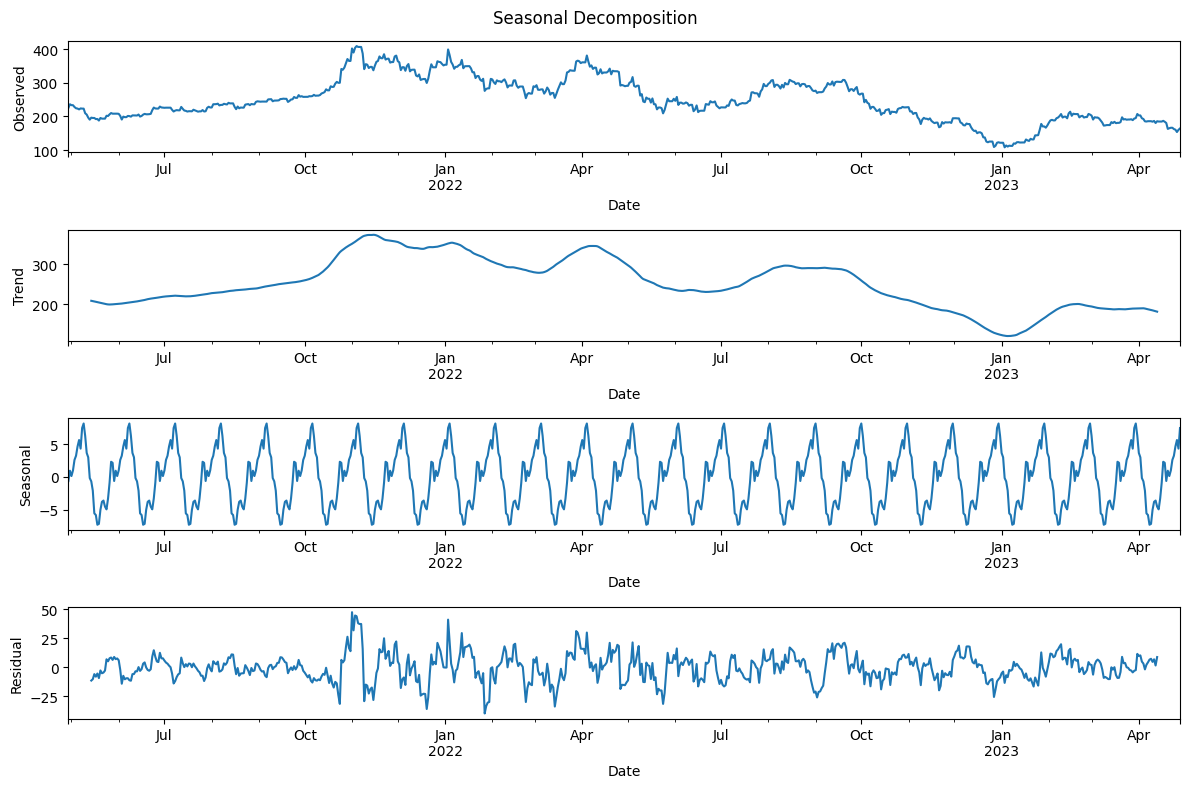

In [25]:
df1.index = df1.Date
decomposition1 = sm.tsa.seasonal_decompose(df1.Close, model='multiplicative',period = 30)

fig1, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12,8))
decomposition1.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
fig1.suptitle('Seasonal Decomposition')
plt.tight_layout()
plt.show()

###Checking If Data is Stationary

In [26]:
#Augmented Dickey-Fuller (ADF) test
adf_test = adfuller(df1['Close'])
print('p-value:',adf_test[1])

p-value: 0.4701647380935413


p-value > 0.05, Therefore data is non-stationary

#Forecasting with various models

We choose Root Mean Squared Error(RMSE) and Mean Absolute Percentage Error(MAPE) to compare the models. Lower the value of RMSE and MAPE, better is the model

In [27]:
#Splitting the data
train_len = 365
train = df1[0 : train_len]
test = df1[train_len : ]

##1. Simple Moving Average

In [28]:
df1_sma = df1.copy()
df1_sma['forecast'] = df1_sma['Close'].rolling(12).mean()

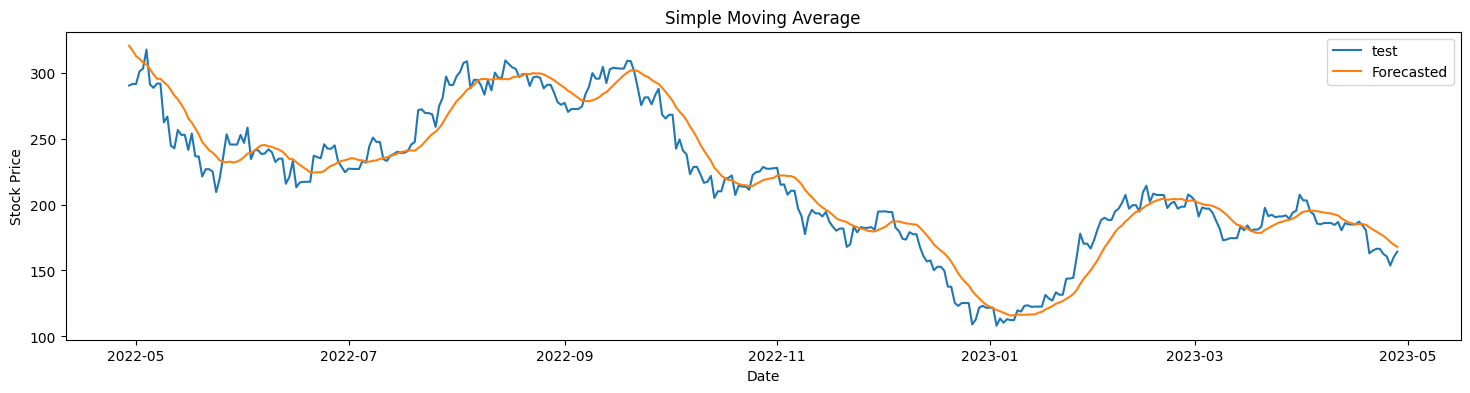

In [131]:
#Plotting test Vs Forecast
plt.figure(figsize=(18,4))
plt.plot(test['Close'], label = 'test')
plt.plot(df1_sma['forecast'][train_len:], label = 'Forecasted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Simple Moving Average')
plt.legend()

In [132]:
#Calculating RMSE and MAPE
rmse_sma = mean_squared_error(test['Close'], df1_sma['forecast'][train_len:], squared=False)
mape_sma = mean_absolute_percentage_error(test['Close'], df1_sma['forecast'][train_len:])
print('Root Mean Squared Error:', rmse_sma)
print(' Mean Absolute Percentage Error', mape_sma)

Root Mean Squared Error: 13.564260977148422
 Mean Absolute Percentage Error 0.052628227635407886


##2. Exponential Smoothing Techniques

###2.1 *Simple Exponential Smoothing*

In [31]:
model = SimpleExpSmoothing(train['Close'])
fit = model.fit(optimized=True)
df1_ses = test.copy()
df1_ses['forecast'] = fit.forecast(test.shape[0])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


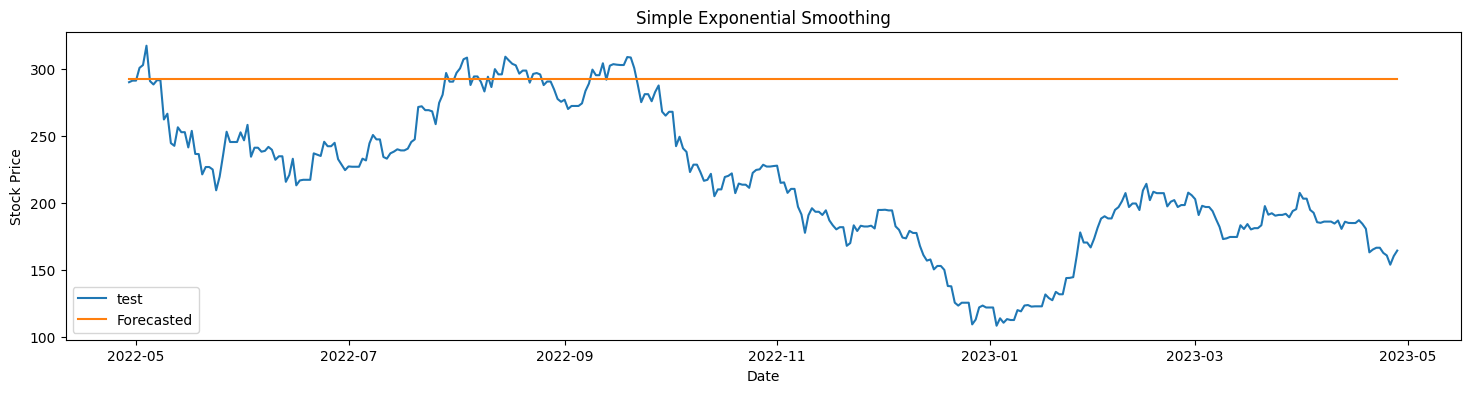

In [133]:
#Plotting test Vs Forecast
plt.figure(figsize=(18,4))
plt.plot(test['Close'], label = 'test')
plt.plot(df1_ses['forecast'], label = 'Forecasted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Simple Exponential Smoothing')
plt.legend()

In [33]:
#Calculating RMSE and MAPE
rmse_ses = mean_squared_error(test['Close'], df1_ses['forecast'], squared=False)
mape_ses = mean_absolute_percentage_error(test['Close'], df1_ses['forecast'])
print('Root Mean Squared Error:', rmse_ses)
print(' Mean Absolute Percentage Error', mape_ses)

Root Mean Squared Error: 91.89410573019232
 Mean Absolute Percentage Error 0.44582048917385303


###2.2 Holt Winters' additive method with trend and seasonality



In [128]:
model = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=12 ,trend='add', seasonal='add')
fit = model.fit(optimized=True)
df1_holtadd = test.copy()
df1_holtadd['forecast'] = fit.forecast(test.shape[0])

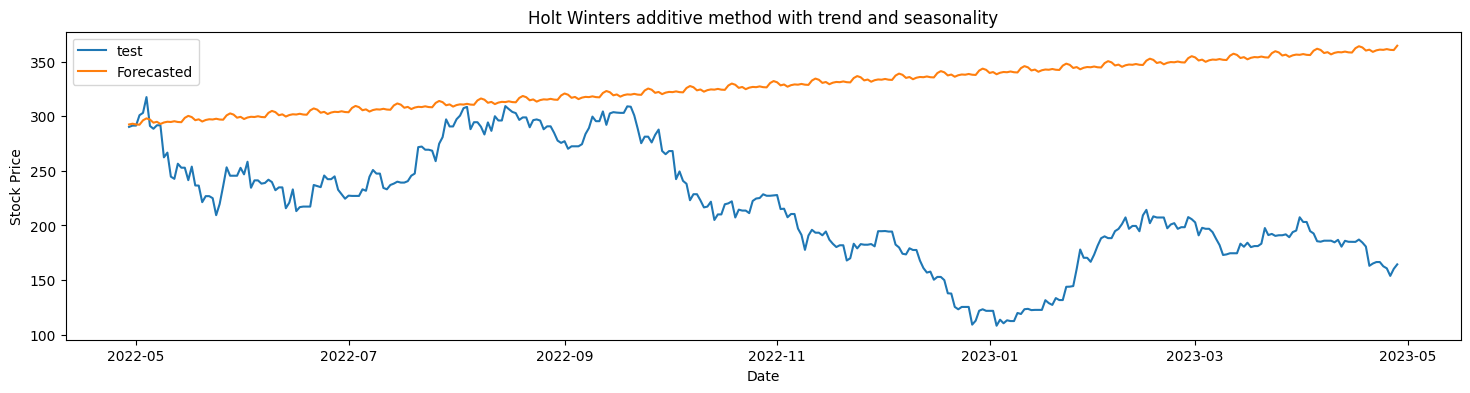

In [134]:
#Plotting test Vs Forecast
plt.figure(figsize=(18,4))
plt.plot(test['Close'], label = 'test')
plt.plot(df1_holtadd['forecast'], label = 'Forecasted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Holt Winters additive method with trend and seasonality')
plt.legend()

In [130]:
#Calculating RMSE and MAPE
rmse_holtadd = mean_squared_error(test['Close'], df1_holtadd['forecast'], squared=False)
mape_holtadd = mean_absolute_percentage_error(test['Close'], df1_holtadd['forecast'])
print('Root Mean Squared Error:', rmse_holtadd)
print(' Mean Absolute Percentage Error', mape_holtadd)

Root Mean Squared Error: 129.82438868864304
 Mean Absolute Percentage Error 0.6310667666134535


###2.2 Holt Winters' multiplicative method with trend and seasonality

In [37]:
model = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=12 ,trend='mul', seasonal='mul')
fit = model.fit(optimized=True)
df1_holtmul = test.copy()
df1_holtmul['forecast'] = fit.forecast(len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


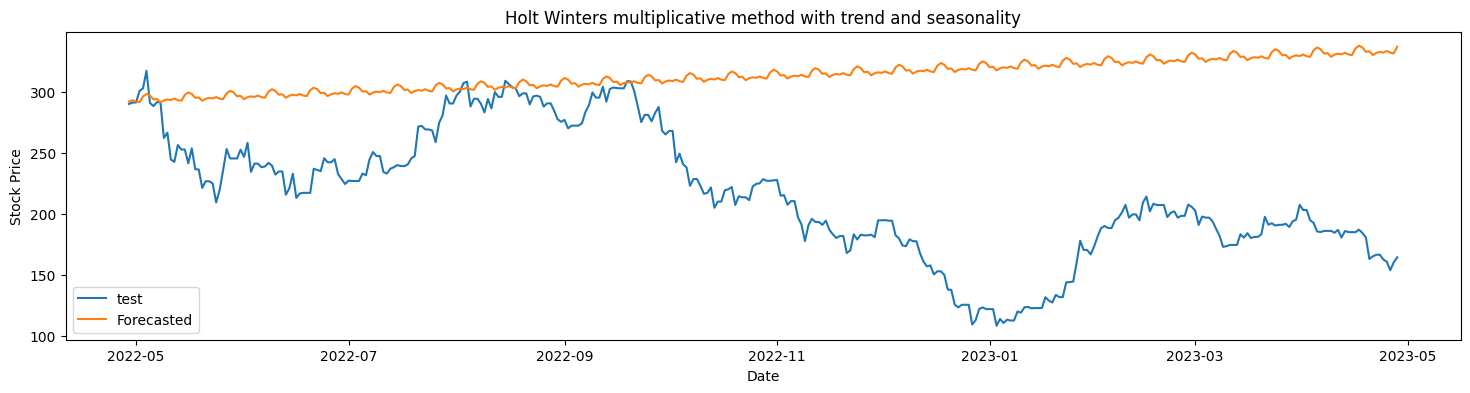

In [135]:
#Plotting test Vs Forecast
plt.figure(figsize=(18,4))
plt.plot(test['Close'], label = 'test')
plt.plot(df1_holtmul['forecast'], label = 'Forecasted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Holt Winters multiplicative method with trend and seasonality')
plt.legend()

In [39]:
#Calculating RMSE and MAPE
rmse_holtmul = mean_squared_error(test['Close'], df1_holtmul['forecast'], squared=False)
mape_holtmul = mean_absolute_percentage_error(test['Close'], df1_holtmul['forecast'])
print('Root Mean Squared Error:', rmse_holtmul)
print(' Mean Absolute Percentage Error', mape_holtmul)

Root Mean Squared Error: 114.10174993156144
 Mean Absolute Percentage Error 0.5535703181820725


#3 Autoregressive Methods

First we need to make data stationary since these models assume stationary data i.e constant variance and mean. For this we will perform transformation and differencing

In [40]:
#Transforming the data
pt = PowerTransformer()
pt.fit(train['Close'].values.reshape(-1,1))
train_arp = pd.Series(pt.transform(train['Close'].values.reshape(-1,1)).flatten(), index = train.index)
test_arp = pd.Series(pt.transform(test['Close'].values.reshape(-1,1)).flatten(), index = test.index)

In [41]:
#Differrencing the data
train_ar = train_arp.diff().dropna()
test_ar = test_arp.diff().dropna()

In [42]:
adf_test = adfuller(train_ar)
print('p-value:',adf_test[1])

p-value: 7.134826795890013e-09


In [43]:
adf_test = adfuller(test_ar)
print('p-value:',adf_test[1])

p-value: 0.0


Both p-values < 0.05, Hence Data is stationary now

##3.1 Auto Regressive model (ARMA)

In [44]:
model = ARIMA(train_ar, order=(2,0,1))
fit = model.fit()
df1_arma = test_ar.to_frame()
df1_arma.head()
df1_arma['forecast'] = fit.predict(df1_arma.index.min(), df1_arma.index.max())
df1_arma['forecast'] = df1_arma['forecast'].cumsum()
df1_arma['forecast'] = df1_arma['forecast'] + train_arp[-1]
df1_arma['forecast'] = pt.inverse_transform(df1_arma['forecast'].values.reshape(-1,1))
df1_arma.head()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,0,forecast
Date,,
2022-04-30,0.019493,293.334828
2022-05-01,0.000000,292.925431
2022-05-02,0.154050,293.727829
2022-05-03,0.033311,293.355303
2022-05-04,0.222960,294.122006


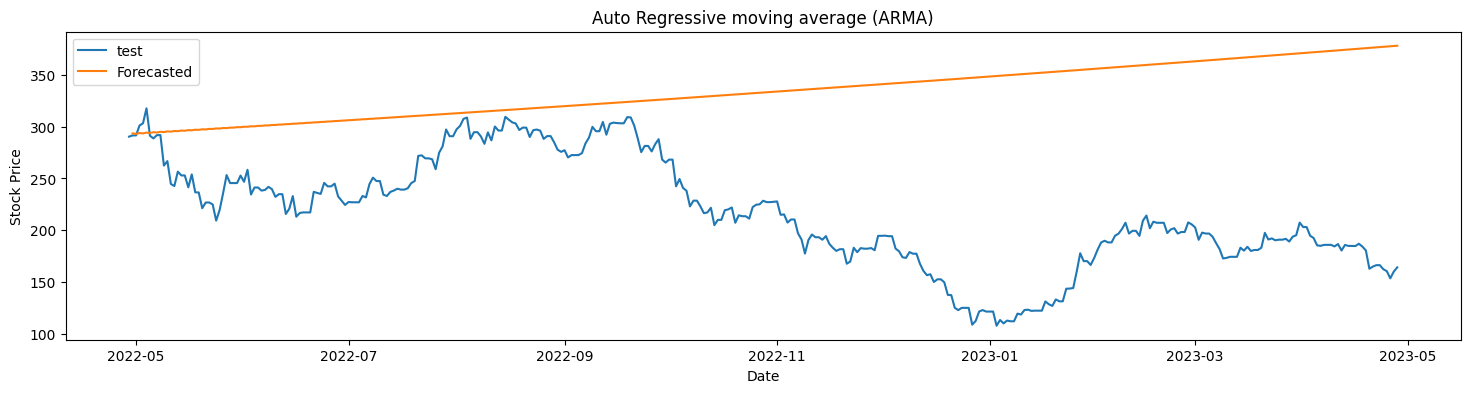

In [143]:
#Plotting test Vs Forecast
plt.figure(figsize=(18,4))
plt.plot(test['Close'], label = 'test')
plt.plot(df1_arma['forecast'], label = 'Forecasted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Auto Regressive moving average (ARMA)')
plt.legend()

In [46]:
#Calculating RMSE and MAPE
rmse_arma = mean_squared_error(test['Close'][1:], df1_arma['forecast'], squared=False)
mape_arma = mean_absolute_percentage_error(test['Close'][1:], df1_arma['forecast'])
print('Root Mean Squared Error:', rmse_arma)
print(' Mean Absolute Percentage Error', mape_arma)

Root Mean Squared Error: 136.8043931340271
 Mean Absolute Percentage Error 0.6644077335013995


##3.2 Auto regressive integrated moving average (ARIMA)


In [140]:
model = ARIMA(train_ar, order=(1, 1, 1))
fit = model.fit()
df1_arima = test_ar.to_frame()
df1_arima.head()
df1_arima['forecast'] = fit.predict(df1_arima.index.min(), df1_arima.index.max())
df1_arima['forecast'] = df1_arima['forecast'].cumsum() + train_arp[-1]
df1_arima['forecast'] = pt.inverse_transform(df1_arima['forecast'].values.reshape(-1,1))
df1_arima.head()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,0,forecast
Date,,
2022-04-30,0.019493,292.705081
2022-05-01,0.000000,292.911786
2022-05-02,0.154050,293.118372
2022-05-03,0.033311,293.325117
2022-05-04,0.222960,293.532005


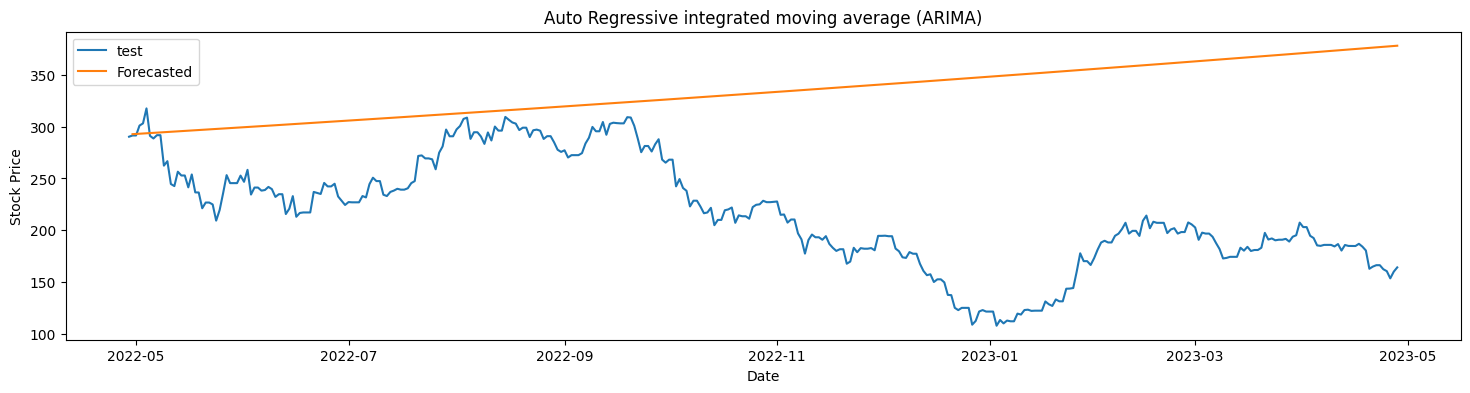

In [141]:
#Plotting test Vs Forecast
plt.figure(figsize=(18,4))
plt.plot(test['Close'], label = 'test')
plt.plot(df1_arima['forecast'], label = 'Forecasted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Auto Regressive integrated moving average (ARIMA)')
plt.legend()

In [142]:
#Calculating RMSE and MAPE
rmse_arima = mean_squared_error(test['Close'][1:], df1_arima['forecast'], squared=False)
mape_arima = mean_absolute_percentage_error(test['Close'][1:], df1_arima['forecast'])
print('Root Mean Squared Error:', rmse_arima)
print(' Mean Absolute Percentage Error', mape_arima)

Root Mean Squared Error: 136.74468655569947
 Mean Absolute Percentage Error 0.6638826270278059


##3.3 Seasonal Auto Regressive integrated moving average (SARIMA)


In [50]:
model = ARIMA(train_ar, order=(1, 1, 1),seasonal_order=(0, 1, 1, 6))
fit = model.fit()
df1_sarima = test_ar.to_frame()
df1_sarima.head()
df1_sarima['forecast'] = fit.predict(df1_sarima.index.min(), df1_sarima.index.max())
df1_sarima['forecast'] = df1_sarima['forecast'].cumsum() + train_arp[-1]
df1_sarima['forecast'] = pt.inverse_transform(df1_sarima['forecast'].values.reshape(-1,1))
df1_sarima.head()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,0,forecast
Date,,
2022-04-30,0.019493,290.858827
2022-05-01,0.000000,290.807664
2022-05-02,0.154050,289.372561
2022-05-03,0.033311,291.145181
2022-05-04,0.222960,291.737175


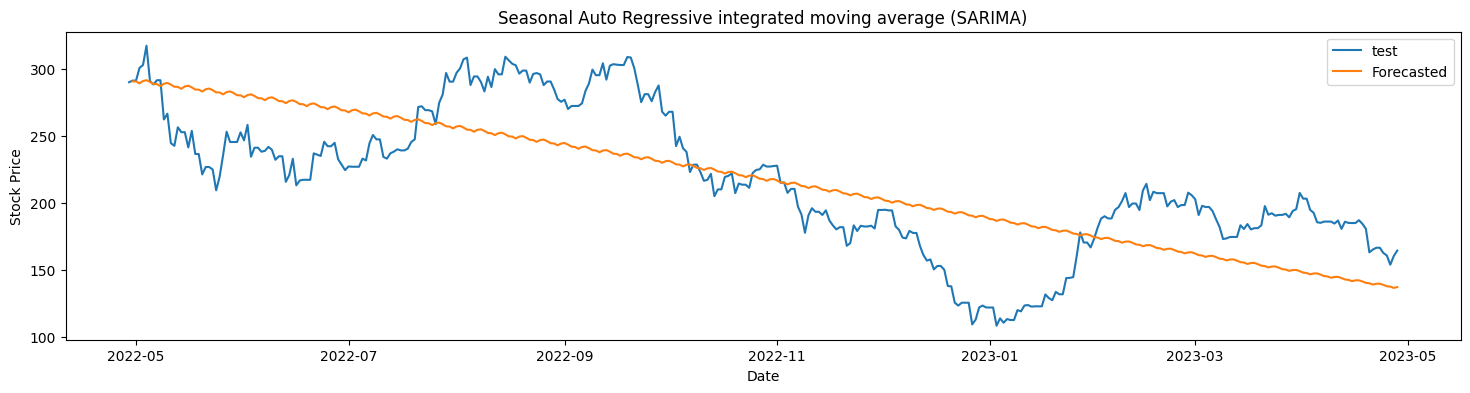

In [138]:
#Plotting test Vs Forecast
plt.figure(figsize=(18,4))
plt.plot(test['Close'], label = 'test')
plt.plot(df1_sarima['forecast'], label = 'Forecasted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Seasonal Auto Regressive integrated moving average (SARIMA)')
plt.legend()

In [150]:
#Calculating RMSE and MAPE
rmse_sarima = mean_squared_error(test['Close'][1:], df1_sarima['forecast'], squared=False)
mape_sarima = mean_absolute_percentage_error(test['Close'][1:], df1_sarima['forecast'])
print('Root Mean Squared Error:', rmse_sarima)
print(' Mean Absolute Percentage Error', mape_sarima)

Root Mean Squared Error: 39.320288633712835
 Mean Absolute Percentage Error 0.17770979219497643


#4. Prophet Model

In [53]:
model = Prophet( changepoint_range=0.5,changepoint_prior_scale=1)

train_prophet = train.copy()
train_prophet = train_prophet.rename(columns={'Date': 'ds', 'Close': 'y'})

test_prophet = test.copy()
test_prophet = test_prophet.rename(columns={'Date': 'ds', 'Close': 'y'})

In [54]:
model.fit(train_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl7z9bdeu/rlgnbz32.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl7z9bdeu/2bq2728i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53593', 'data', 'file=/tmp/tmpl7z9bdeu/rlgnbz32.json', 'init=/tmp/tmpl7z9bdeu/2bq2728i.json', 'output', 'file=/tmp/tmpl7z9bdeu/prophet_model8xvdmy5t/prophet_model-20230429163853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:38:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:38:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [55]:
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)
forecast = forecast[-len(test):]
forecast.index = test_prophet.index

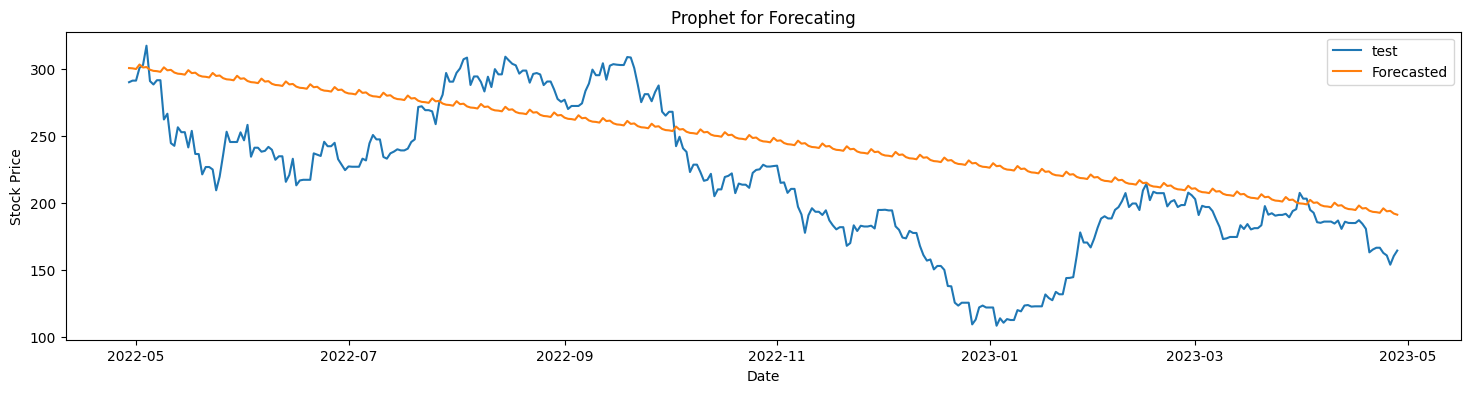

In [137]:
#Plotting test Vs Forecast
plt.figure(figsize=(18,4))
plt.plot(test['Close'], label = 'test')
plt.plot(forecast['yhat'], label = 'Forecasted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Prophet for Forecating')
plt.legend()

In [149]:
#Calculating RMSE and MAPE
rmse_prophet = mean_squared_error(test['Close'], forecast['yhat'], squared=False)
mape_prophet = mean_absolute_percentage_error(test['Close'], forecast['yhat'])
print('Root Mean Squared Error:', rmse_sarima)
print(' Mean Absolute Percentage Error', mape_sarima)

Root Mean Squared Error: 39.320288633712835
 Mean Absolute Percentage Error 0.2231241516646041


##5. LSTM

In [101]:
scaler = MinMaxScaler()
scaler = MinMaxScaler()
train_lstm = scaler.fit_transform(train[['Close']])
test_lstm = scaler.transform(test[['Close']])

In [103]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, :])
    return np.array(X), np.array(y)

In [104]:
seq_length = 10
X_train, y_train = create_sequences(train_lstm, seq_length)
X_test, y_test = create_sequences(test_lstm, seq_length)

In [106]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

In [107]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
12/12 [==============================] - 12s 6ms/step - loss: 0.0860
Epoch 2/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0190
Epoch 3/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0112
Epoch 4/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0085
Epoch 5/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0076
Epoch 6/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0070
Epoch 7/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0068
Epoch 8/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 9/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 10/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 11/50
12/12 [==============================] - 0s 7ms/step - loss: 0.0061
Epoch 12/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0060
Epoch 13/50
12/12 [=============================

In [115]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

12/12 [==============================] - 0s 3ms/step


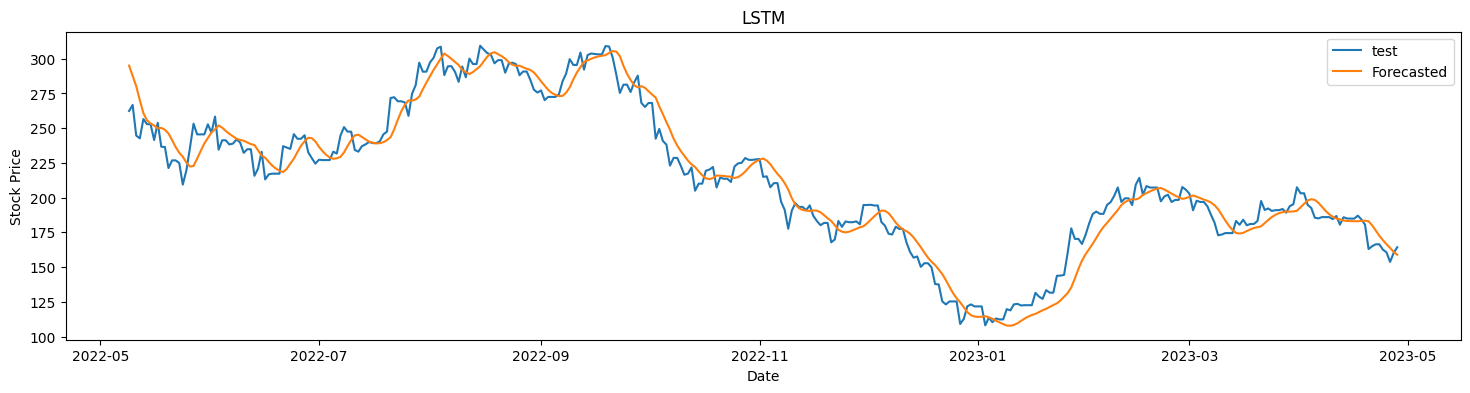

In [136]:
#Plotting test Vs Forecast
plt.figure(figsize=(18,4))
plt.plot(test.index[seq_length:], y_test[:, 0], label='test')
plt.plot(test.index[seq_length:], y_pred[:, 0], label='Forecasted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('LSTM')
plt.legend()
plt.show()

In [121]:
#Calculating RMSE and MAPE
rmse_lstm = mean_squared_error(y_test[:, 0], y_pred[:, 0], squared=False)
mape_lstm = mean_absolute_percentage_error(y_test[:, 0], y_pred[:, 0])
print('Root Mean Squared Error:', rmse_lstm)
print(' Mean Absolute Percentage Error', mape_lstm)

Root Mean Squared Error: 11.167545099942851
 Mean Absolute Percentage Error 0.04433300259639803


In [152]:
results = pd.DataFrame({'Models': ['Simple Moving Average', 'Simple Exponential Smoothing','Holt Winters' +'additive method with trend and seasonality','Holt Winters' +'multiplicative method with trend and seasonality','ARMA','ARIMA','SARIMA', 'Prophet','LSTM' ],
                        'RMSE':[rmse_sma,rmse_ses,rmse_holtadd,rmse_holtmul,rmse_arma,rmse_arima, rmse_sarima,rmse_prophet, rmse_lstm],
                        'MAPE':[mape_sma,mape_ses,mape_holtadd,mape_holtmul,mape_arma,mape_arima, mape_sarima,mape_prophet, mape_lstm],
                        })
results

,Models,RMSE,MAPE
0,Simple Moving Average,13.564261,0.052628
1,Simple Exponential Smoothing,91.894106,0.445820
2,Holt Wintersadditive method with trend and sea...,129.824389,0.631067
3,Holt Wintersmultiplicative method with trend a...,114.101750,0.553570
4,ARMA,136.804393,0.664408
5,ARIMA,136.744687,0.663883
6,SARIMA,39.320289,0.177710
7,Prophet,48.871673,0.223124
8,LSTM,11.167545,0.044333


In [153]:
results.to_csv('results.csv', index = False)